# CNN Model Testing Complex
Used to test audio that are mixes of songs and ads. Alternates songs and ads stored in:
- /resampled_testing_ads
- /resampled_testing_songs

to create a single audio input. Takes a sliding 5 second long window of the input (stride is configurable), each of which is processed and fed to a corresponding model. These results are then collected and plotted. Afterwards, an algorithm is applied to remove the ads from the songs. The resulting audio files are then outputted to /testing_audio.

Requires saved models from either:
* `cnn_mfcc.ipynb`
* `cnn_mfcc_delta.ipynb`
* `cnn_raw.ipynb`

Requires audio from:
* `resampleAudio_testing.m`
* `resampleRun_testing.m`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy
from scipy.io import wavfile

# Initialize, Get Songs, Get Ads

In [2]:
# Initialize some Parameters
song_dir = "resampled_testing_songs" # song directory
ad_dir   = "resampled_testing_ads" #ad directory
sr = 44100 # sampling rate
song_data = []
ad_data = []

In [3]:
# Load in all songs from song directory
num_songs = 0
for filename in os.listdir(song_dir):
    # Check if the file is a WAV file
    if filename.endswith('.wav'):
        num_songs += 1
        # Construct the full path to the file
        filepath = os.path.join(song_dir, filename)
        [data, sr_dc] = librosa.load(filepath, sr=sr)
        song_data.append(data)
print(f"Num Songs is: {num_songs}")

Num Songs is: 5


In [4]:
# Load in all ads from ad directory
num_ads = 0
for filename in os.listdir(ad_dir):
    # Check if the file is a WAV file
    if filename.endswith('.wav'):
        num_ads += 1
        numClips = 0
        # Construct the full path to the file
        filepath = os.path.join(ad_dir, filename)
        [data, sr_dc] = librosa.load(filepath, sr=sr)
        ad_data.append(data)
print(f"Num Ads is: {num_ads}")

Num Ads is: 5


# Load Saved CNN Models

In [5]:
# Define our CNNs

# CNN using only mfccs
class mfcc_CNN(nn.Module):
    def __init__(self):
        super(mfcc_CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(6784, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output into a 1D vector for use in the fully connected layers
        size = x.size()[1:]  #all size except batchSize
        numFeatures = 1
        for s in size:
            numFeatures *= s
        x = x.view(-1, numFeatures)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        #x = torch.sigmoid(self.fc2(x))
        x = self.fc2(x)
        return x

# CNN using mfccs + delta features
class mfcc_d_CNN(nn.Module):
    def __init__(self):
        super(mfcc_d_CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(6784, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output into a 1D vector for use in the fully connected layers
        size = x.size()[1:]  #all size except batchSize
        numFeatures = 1
        for s in size:
            numFeatures *= s
        x = x.view(-1, numFeatures)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        #x = torch.sigmoid(self.fc2(x))
        x = self.fc2(x)
        return x

# CNN using only raw data
class raw_CNN(nn.Module):
    def __init__(self):
        super(raw_CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv1d(1,  32,  kernel_size=10, padding=1)
        self.conv2 = nn.Conv1d(32, 64,  kernel_size=5, padding=1)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        
        # Pooling layer
        self.pool = nn.AvgPool1d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(3527808, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the output for fully connected layers
        size = x.size()[1:]  #all size except batchSize
        numFeatures = 1
        for s in size:
            numFeatures *= s
        x = x.view(-1, numFeatures)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# Get model filenames
mfcc_model_name       = os.path.join("models", "cnn_mfcc_model_testing.pth")
mfcc_delta_model_name = os.path.join("models", "cnn_mfcc_delta_model_testing.pth")
raw_model_name        = os.path.join("models", "cnn_raw_model_batch_100_epoch_5.pth")

# Load the state dictionarys
state_dict_1 = torch.load(mfcc_model_name)
state_dict_2 = torch.load(mfcc_delta_model_name)
state_dict_3 = torch.load(raw_model_name)

# Create instances of model
model_mfcc   = mfcc_CNN()
model_mfcc_d = mfcc_d_CNN()
model_raw    = raw_CNN()

# Load the state dictionarys into the models
model_mfcc.load_state_dict(state_dict_1)
model_mfcc_d.load_state_dict(state_dict_2)
model_raw.load_state_dict(state_dict_3)

# Set the models to evaluation mode
model_mfcc.eval()
model_mfcc_d.eval()
model_raw.eval()


raw_CNN(
  (conv1): Conv1d(1, 32, kernel_size=(10,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(1,))
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (fc1): Linear(in_features=3527808, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

# Initialize Windowing Parameters and Functions

In [7]:
# Initialize parameters
seconds_per_window = 5

win_length = 5*sr

win_div = 10

window_stride = win_length//win_div

# Define get window function
def get_window(audio, begin, window_size):
    return audio[(begin):(begin+window_size)]

# Create Test Audio Input

audio length is: (61984421,)
correct_eval length is: (61984421,)


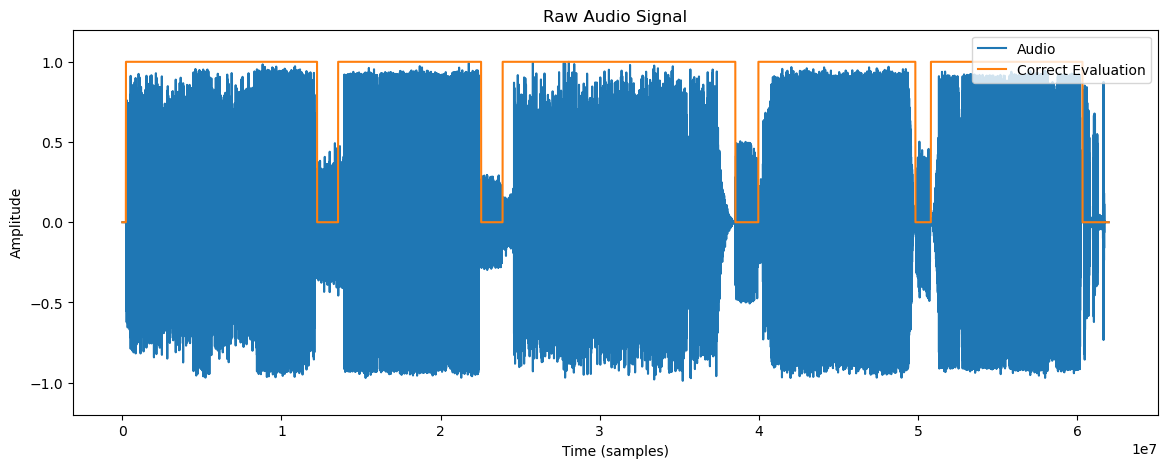

In [8]:
# Mix together alternating songs and ads
audio = []
correct_eval = []
for i in range(len(song_data) + len(ad_data)):
    if(i % 2 == 0):
        audio.extend(song_data[i//2])
        correct_eval.extend(np.ones(len(song_data[i//2])))
    else:
        audio.extend(ad_data[i//2])
        correct_eval.extend(np.zeros(len(ad_data[i//2])))

audio = np.array(audio).astype(dtype=np.float32)
audio = np.pad(audio, (win_length, win_length), mode='constant')
correct_eval = np.array(correct_eval).astype(dtype=np.int64)
correct_eval = np.pad(correct_eval, (win_length, win_length), mode='constant')

print(f"audio length is: {audio.shape}")
print(f"correct_eval length is: {correct_eval.shape}")

# write newly created audio input file
wavfile.write(os.path.join("testing_audio", "complex.wav"), sr, audio)

# plot audio
plt.figure(figsize=(14, 5))
plt.plot(audio, label="Audio")
plt.plot(correct_eval, label="Correct Evaluation")
plt.legend(loc='upper right')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
#plt.xlim(-1.2, 1.2) 
plt.ylim(-1.2, 1.2)
plt.title('Raw Audio Signal')
plt.savefig(os.path.join("graphics", "mfcc_audio.png"), transparent=True)
plt.show()

# Evaluate Audio (MFCC)

In [9]:
# evaluate audio (MFCC)
temp = librosa.feature.mfcc(y=audio[0:win_length], sr=sr, n_mfcc=13)[1:].T
mfccs = np.empty((1, 1, temp.shape[0], temp.shape[1]), dtype=np.float32)
print(f"tensor shape: {mfccs.shape}")

audio_eval_mfcc = []
song_confidence_mfcc = []
ad_confidence_mfcc = []

# sliding window evaluation
for i in range(0, len(audio) - win_length, window_stride):
    window = get_window(audio, i, win_length)
    mfccs[0][0] = librosa.feature.mfcc(y=window, sr=sr, n_mfcc=13)[1:].T
    mfccs_tensor = torch.tensor(mfccs, dtype=torch.float32)
    output = model_mfcc(mfccs_tensor)
    prediction = torch.max(output.data, 1)
    audio_eval_mfcc.extend([0 if x == 0 else 1 for x in prediction.indices])
    ad_confidence_mfcc.append(output.data[0][0])
    song_confidence_mfcc.append(output.data[0][1])

# expand eval list to be the same length as input for processing
x = len(audio) // len(audio_eval_mfcc)
temp1 = np.ones(x)
temp0 = np.zeros(x)
temp_eval = []
for i in range(0, len(audio_eval_mfcc)):
    if(audio_eval_mfcc[i] == 1):
        temp_eval.extend(temp1)
    else:
        temp_eval.extend(temp0)
audio_eval_mfcc = temp_eval

tensor shape: (1, 1, 431, 12)


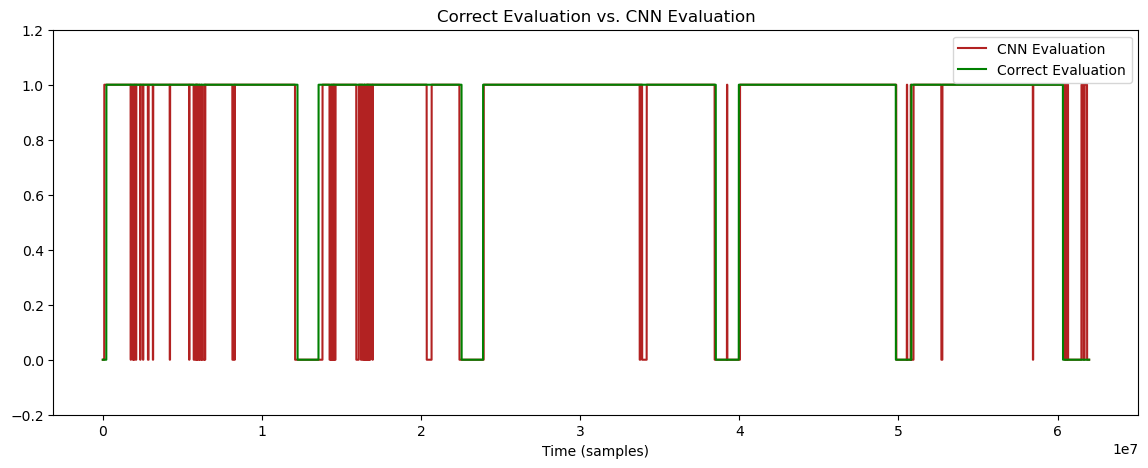

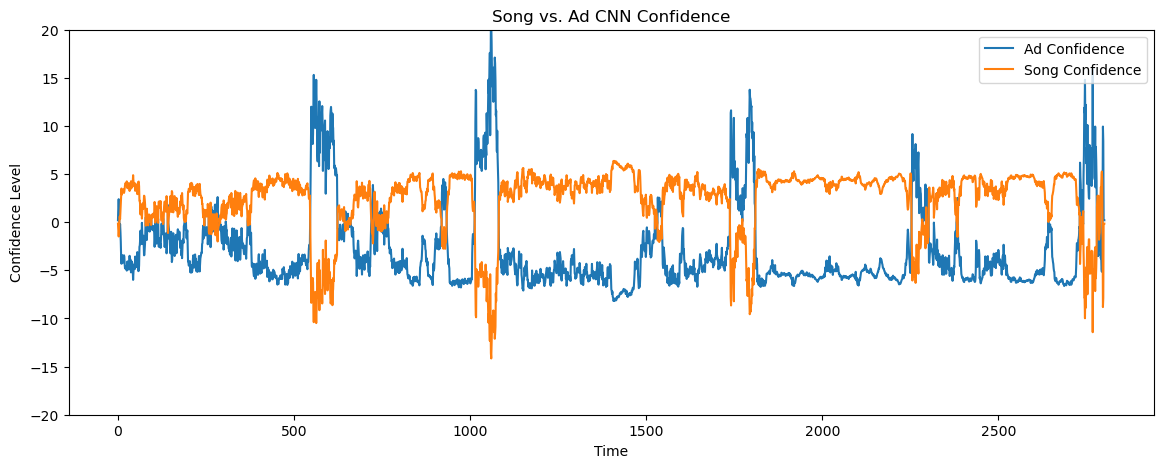

In [10]:
# plot correct eval vs eval
plt.figure(figsize=(14, 5))
plt.plot(audio_eval_mfcc, label="CNN Evaluation", color='firebrick')
plt.plot(correct_eval, label="Correct Evaluation", color='green')
plt.legend(loc='upper right')
plt.xlabel('Time (samples)')
#plt.xlim(-1.2, 1.2) 
plt.ylim(-0.2, 1.2)
plt.title('Correct Evaluation vs. CNN Evaluation')
plt.savefig(os.path.join("graphics", "mfcc_eval.png"), transparent=True)
plt.show()

# plot confidences
plt.figure(figsize=(14, 5))
plt.plot(ad_confidence_mfcc, label='Ad Confidence')
plt.plot(song_confidence_mfcc, label='Song Confidence')
plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Confidence Level')
#plt.xlim(-1.2, 1.2) 
plt.ylim(-20, 20)
plt.title('Song vs. Ad CNN Confidence')
plt.savefig(os.path.join("graphics", "mfcc_confidence.png"), transparent=True)
plt.show()

# Remove Ads (MFCC)

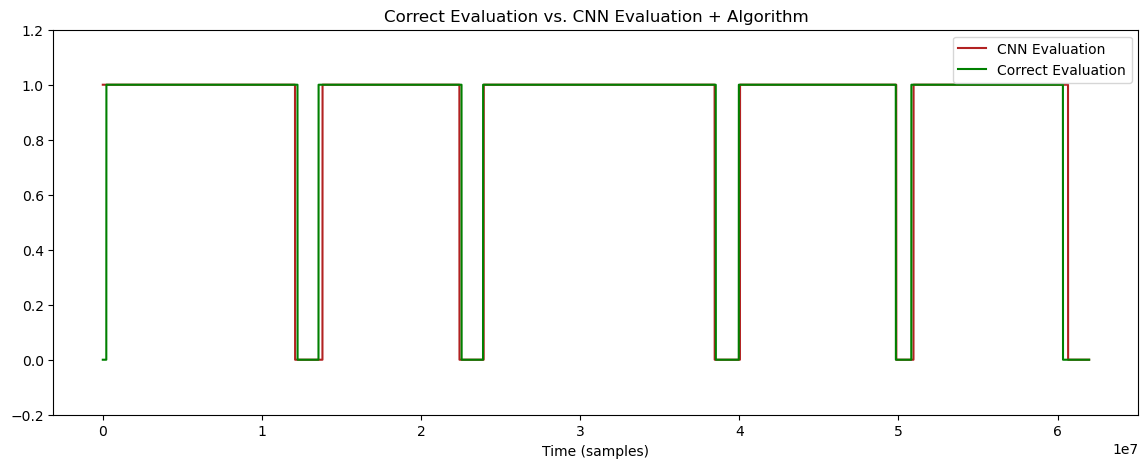

Original Length: 61984421 samples
New Length-Mute: 61983042 samples
New Length-Remove: 54727354 samples


In [11]:
# remove Ads 1 (MFCC)
old_eval = audio_eval_mfcc
algo_eval = []
state = 1
song_tally = 0
ad_tally = 0
threshold = 10*sr # 10 consecutive seconds
    
for i in range(threshold, len(old_eval)):
    if(state == 0):
        algo_eval.append(0)
    else:
        algo_eval.append(1)
    if(old_eval[i] == 0):
        song_tally = 0
        ad_tally += 1
    else:
        ad_tally = 0
        song_tally += 1
    if(song_tally == threshold):
        state = 1
    elif(ad_tally == threshold):
        state = 0

if(state == 1):
    algo_eval.extend(np.ones(threshold))
else:
    algo_eval.extend(np.zeros(threshold))

# plot eval old + new
plt.figure(figsize=(14, 5))
plt.plot(algo_eval, label="CNN Evaluation", color='firebrick')
plt.plot(correct_eval, label="Correct Evaluation", color='green')
plt.legend(loc='upper right')
plt.xlabel('Time (samples)')
#plt.xlim(-1.2, 1.2) 
plt.ylim(-0.2, 1.2)
plt.title('Correct Evaluation vs. CNN Evaluation + Algorithm')
plt.savefig(os.path.join("graphics", "mfcc_eval_algo_1.png"), transparent=True)
plt.show()

# remove/mute ads
audio_out_mute = []
audio_out_remove = []
for i in range(0, len(algo_eval)):
    if(algo_eval[i] == 0):
        audio_out_mute.append(0)
    else:
        audio_out_mute.append(audio[i])
        audio_out_remove.append(audio[i])

print(f"Original Length: {len(audio)} samples")
print(f"New Length-Mute: {len(audio_out_mute)} samples")
print(f"New Length-Remove: {len(audio_out_remove)} samples")

In [12]:
# write edited audio file
audio_out = np.array(audio_out_mute, dtype=np.float32)
wavfile.write(os.path.join("testing_audio", "mfcc_output_mute_1.wav"), sr, audio_out)
audio_out = np.array(audio_out_remove, dtype=np.float32)
wavfile.write(os.path.join("testing_audio", "mfcc_output_removed_1.wav"), sr, audio_out)

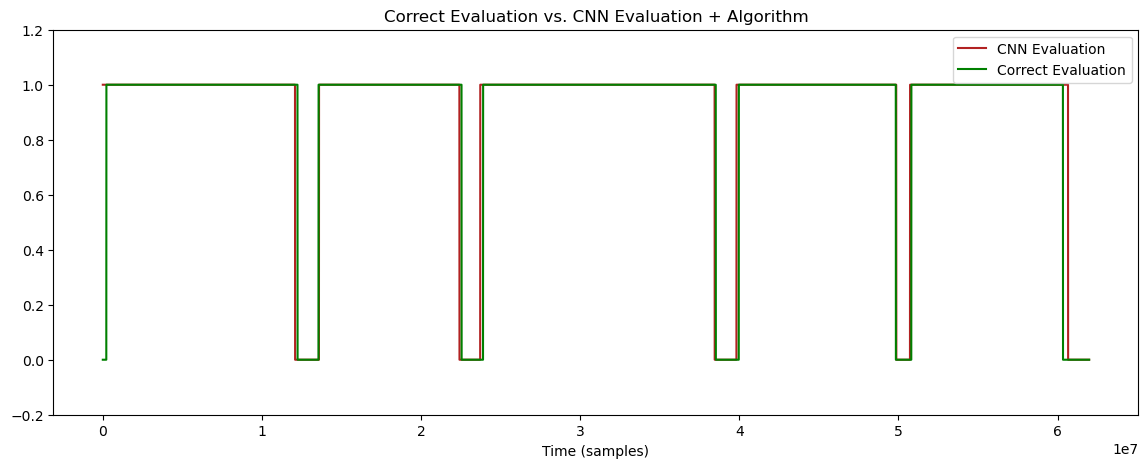

Original Length: 61984421 samples
New Length-Mute: 61983042 samples
New Length-Remove: 55609354 samples


In [13]:
# remove Ads 2 (MFCC) w/ less stringent song threshold
old_eval = audio_eval_mfcc
algo_eval = []
state = 1
song_tally = 0
ad_tally = 0
threshold = 10*sr # 10 consecutive seconds
    
for i in range(threshold, len(old_eval)):
    if(state == 0):
        algo_eval.append(0)
    else:
        algo_eval.append(1)
    if(old_eval[i] == 0):
        song_tally = 0
        ad_tally += 1
    else:
        ad_tally = 0
        song_tally += 1
    if(song_tally == threshold//2):
        state = 1
    elif(ad_tally == threshold):
        state = 0

if(state == 1):
    algo_eval.extend(np.ones(threshold))
else:
    algo_eval.extend(np.zeros(threshold))

# plot eval old + new
plt.figure(figsize=(14, 5))
plt.plot(algo_eval, label="CNN Evaluation", color='firebrick')
plt.plot(correct_eval, label="Correct Evaluation", color='green')
plt.legend(loc='upper right')
plt.xlabel('Time (samples)')
#plt.xlim(-1.2, 1.2) 
plt.ylim(-0.2, 1.2)
plt.title('Correct Evaluation vs. CNN Evaluation + Algorithm')
plt.savefig(os.path.join("graphics", "mfcc_eval_algo_2.png"), transparent=True)
plt.show()

# remove/mute ads
audio_out_mute = []
audio_out_remove = []
for i in range(0, len(algo_eval)):
    if(algo_eval[i] == 0):
        audio_out_mute.append(0)
    else:
        audio_out_mute.append(audio[i])
        audio_out_remove.append(audio[i])

print(f"Original Length: {len(audio)} samples")
print(f"New Length-Mute: {len(audio_out_mute)} samples")
print(f"New Length-Remove: {len(audio_out_remove)} samples")

In [14]:
# write edited audio file
audio_out = np.array(audio_out_mute, dtype=np.float32)
wavfile.write(os.path.join("testing_audio", "mfcc_output_mute_2.wav"), sr, audio_out)
audio_out = np.array(audio_out_remove, dtype=np.float32)
wavfile.write(os.path.join("testing_audio", "mfcc_output_removed_2.wav"), sr, audio_out)

# Evaluate Audio (MFCC + Delta Features)

In [15]:
# evaluate audio (MFCC + delta)
temp = librosa.feature.mfcc(y=audio[0:win_length], sr=sr, n_mfcc=13)[1:].T
mfccs_d = np.empty((1, 3, temp.shape[0], temp.shape[1]), dtype=np.float32)
print(f"tensor shape: {mfccs_d.shape}")

audio_eval_mfcc_d = []
song_confidence_mfcc_d = []
ad_confidence_mfcc_d = []

# sliding window evaluation
for i in range(0, len(audio) - win_length, window_stride):
    window = get_window(audio, i, win_length)
    mfccs_d[0][0] = librosa.feature.mfcc(y=window, sr=sr, n_mfcc=13)[1:].T
    mfccs_d[0][1] = librosa.feature.delta(mfccs_d[0][0].T).T
    mfccs_d[0][2] = librosa.feature.delta(mfccs_d[0][0].T, order=2).T
    mfccs_tensor = torch.tensor(mfccs_d, dtype=torch.float32)
    output = model_mfcc_d(mfccs_tensor)
    prediction = torch.max(output.data, 1)
    audio_eval_mfcc_d.extend([0 if x == 0 else 1 for x in prediction.indices])
    ad_confidence_mfcc_d.append(output.data[0][0])
    song_confidence_mfcc_d.append(output.data[0][1])

# expand eval list to be the same length as input for processing
x = len(audio) // len(audio_eval_mfcc_d)
temp1 = np.ones(x)
temp0 = np.zeros(x)
temp_eval = []
for i in range(0, len(audio_eval_mfcc_d)):
    if(audio_eval_mfcc_d[i] == 1):
        temp_eval.extend(temp1)
    else:
        temp_eval.extend(temp0)
audio_eval_mfcc_d = temp_eval

tensor shape: (1, 3, 431, 12)


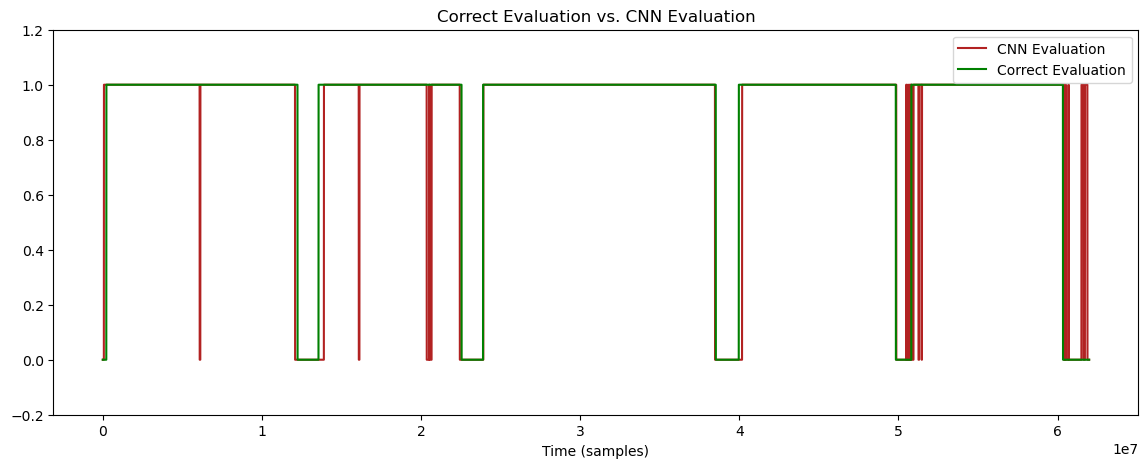

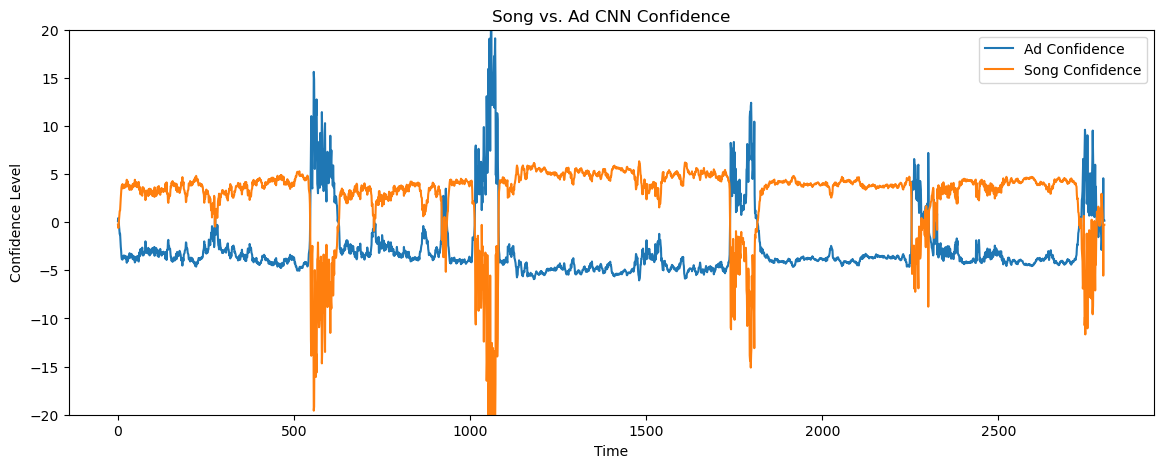

In [16]:
# plot correct eval vs eval
plt.figure(figsize=(14, 5))
plt.plot(audio_eval_mfcc_d, label="CNN Evaluation", color='firebrick')
plt.plot(correct_eval, label="Correct Evaluation", color='green')
plt.legend(loc='upper right')
plt.xlabel('Time (samples)')
#plt.xlim(-1.2, 1.2) 
plt.ylim(-0.2, 1.2)
plt.title('Correct Evaluation vs. CNN Evaluation')
plt.savefig(os.path.join("graphics", "mfcc_d_eval.png"), transparent=True)
plt.show()

# plot confidences
plt.figure(figsize=(14, 5))
plt.plot(ad_confidence_mfcc_d, label='Ad Confidence')
plt.plot(song_confidence_mfcc_d, label='Song Confidence')
plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Confidence Level')
#plt.xlim(-1.2, 1.2) 
plt.ylim(-20, 20)
plt.title('Song vs. Ad CNN Confidence')
plt.savefig(os.path.join("graphics", "mfcc_d_confidence.png"), transparent=True)
plt.show()

# Remove Ads (MFCC + Delta Features)

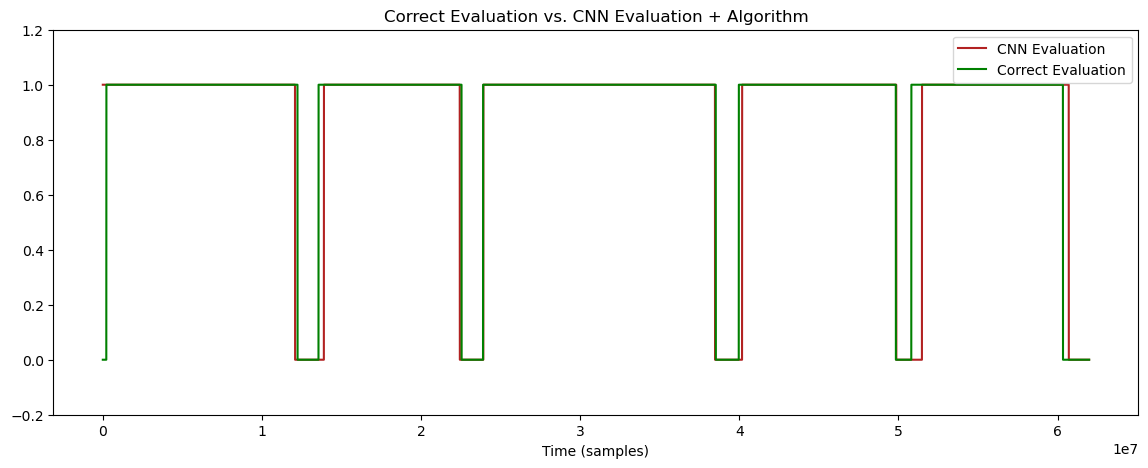

Original Length: 61984421 samples
New Length-Mute: 61983042 samples
New Length-Remove: 54085845 samples


In [17]:
# remove Ads 1 (MFCC + delta)
old_eval = audio_eval_mfcc_d
algo_eval = []
state = 1
song_tally = 0
ad_tally = 0
threshold = 10*sr # 10 consecutive seconds
    
for i in range(threshold, len(old_eval)):
    if(state == 0):
        algo_eval.append(0)
    else:
        algo_eval.append(1)
    if(old_eval[i] == 0):
        song_tally = 0
        ad_tally += 1
    else:
        ad_tally = 0
        song_tally += 1
    if(song_tally == threshold):
        state = 1
    elif(ad_tally == threshold):
        state = 0

if(state == 1):
    algo_eval.extend(np.ones(threshold))
else:
    algo_eval.extend(np.zeros(threshold))

# plot eval old + new
plt.figure(figsize=(14, 5))
plt.plot(algo_eval, label="CNN Evaluation", color='firebrick')
plt.plot(correct_eval, label="Correct Evaluation", color='green')
plt.legend(loc='upper right')
plt.xlabel('Time (samples)')
#plt.xlim(-1.2, 1.2) 
plt.ylim(-0.2, 1.2)
plt.title('Correct Evaluation vs. CNN Evaluation + Algorithm')
plt.savefig(os.path.join("graphics", "mfcc_d_eval_algo_1.png"), transparent=True)
plt.show()

# remove/mute ads
audio_out_mute = []
audio_out_remove = []
for i in range(0, len(algo_eval)):
    if(algo_eval[i] == 0):
        audio_out_mute.append(0)
    else:
        audio_out_mute.append(audio[i])
        audio_out_remove.append(audio[i])

print(f"Original Length: {len(audio)} samples")
print(f"New Length-Mute: {len(audio_out_mute)} samples")
print(f"New Length-Remove: {len(audio_out_remove)} samples")

In [18]:
# write edited audio file
audio_out = np.array(audio_out_mute, dtype=np.float32)
wavfile.write(os.path.join("testing_audio", "mfcc_d_output_mute_1.wav"), sr, audio_out)
audio_out = np.array(audio_out_remove, dtype=np.float32)
wavfile.write(os.path.join("testing_audio", "mfcc_d_output_removed_1.wav"), sr, audio_out)

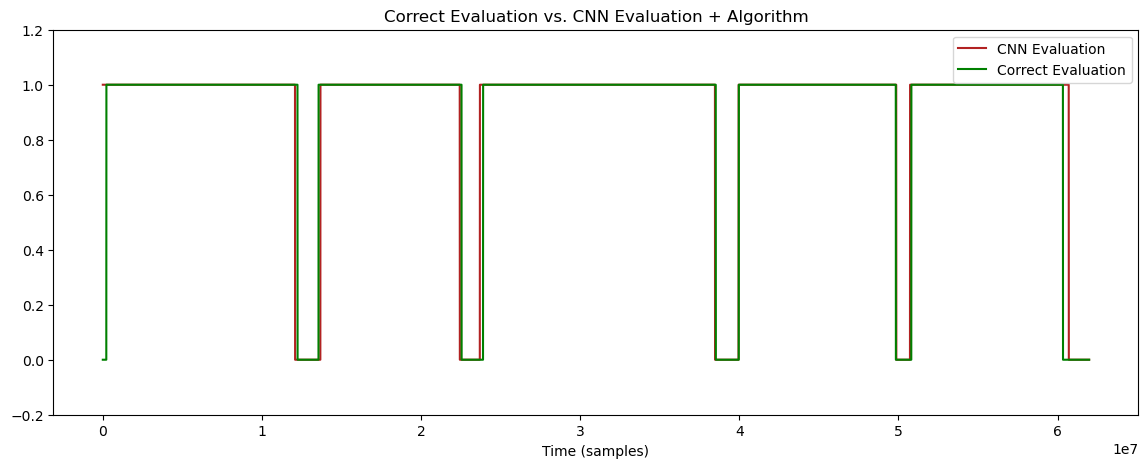

Original Length: 61984421 samples
New Length-Mute: 61983042 samples
New Length-Remove: 55498749 samples


In [19]:
# remove Ads 2 (MFCC + delta) w/ less stringent song threshold
old_eval = audio_eval_mfcc_d
algo_eval = []
state = 1
song_tally = 0
ad_tally = 0
threshold = 10*sr # 10 consecutive seconds
    
for i in range(threshold, len(old_eval)):
    if(state == 0):
        algo_eval.append(0)
    else:
        algo_eval.append(1)
    if(old_eval[i] == 0):
        song_tally = 0
        ad_tally += 1
    else:
        ad_tally = 0
        song_tally += 1
    if(song_tally == threshold//2):
        state = 1
    elif(ad_tally == threshold):
        state = 0

if(state == 1):
    algo_eval.extend(np.ones(threshold))
else:
    algo_eval.extend(np.zeros(threshold))

# plot eval old + new
plt.figure(figsize=(14, 5))
plt.plot(algo_eval, label="CNN Evaluation", color='firebrick')
plt.plot(correct_eval, label="Correct Evaluation", color='green')
plt.legend(loc='upper right')
plt.xlabel('Time (samples)')
#plt.xlim(-1.2, 1.2) 
plt.ylim(-0.2, 1.2)
plt.title('Correct Evaluation vs. CNN Evaluation + Algorithm')
plt.savefig(os.path.join("graphics", "mfcc_d_eval_algo_2.png"), transparent=True)
plt.show()

# remove/mute ads
audio_out_mute = []
audio_out_remove = []
for i in range(0, len(algo_eval)):
    if(algo_eval[i] == 0):
        audio_out_mute.append(0)
    else:
        audio_out_mute.append(audio[i])
        audio_out_remove.append(audio[i])

print(f"Original Length: {len(audio)} samples")
print(f"New Length-Mute: {len(audio_out_mute)} samples")
print(f"New Length-Remove: {len(audio_out_remove)} samples")

In [20]:
# write edited audio file
audio_out = np.array(audio_out_mute, dtype=np.float32)
wavfile.write(os.path.join("testing_audio", "mfcc_d_output_mute_2.wav"), sr, audio_out)
audio_out = np.array(audio_out_remove, dtype=np.float32)
wavfile.write(os.path.join("testing_audio", "mfcc_d_output_removed_2.wav"), sr, audio_out)

# Evaluate Audio (Raw)
*NOTE: current lack of audio loudness normalization makes raw data not practical. Appears more accurate than it would be in practice.

In [21]:
# evaluate audio (raw)

# update window parameters so it runs in a semi-reasonable amount of non-infinite time
win_div = 1

window_stride = win_length//win_div

window_raw = np.empty((1, 1, win_length))
print(f"tensor shape: {window_raw.shape}")

audio_eval_raw = []
song_confidence_raw = []
ad_confidence_raw = []

# sliding window evaluation
for i in range(0, len(audio) - win_length, window_stride):
    window_raw[0] = get_window(audio, i, win_length)
    raw_tensor = torch.tensor(window_raw, dtype=torch.float32)
    output = model_raw(raw_tensor)
    prediction = torch.max(output.data, 1)
    audio_eval_raw.extend([0 if x == 0 else 1 for x in prediction.indices])
    ad_confidence_raw.append(output.data[0][0])
    song_confidence_raw.append(output.data[0][1])

# expand eval list to be the same length as input for processing
x = len(audio) // len(audio_eval_raw)
temp1 = np.ones(x)
temp0 = np.zeros(x)
temp_eval = []
for i in range(0, len(audio_eval_raw)):
    if(audio_eval_raw[i] == 1):
        temp_eval.extend(temp1)
    else:
        temp_eval.extend(temp0)
audio_eval_raw = temp_eval

tensor shape: (1, 1, 220500)


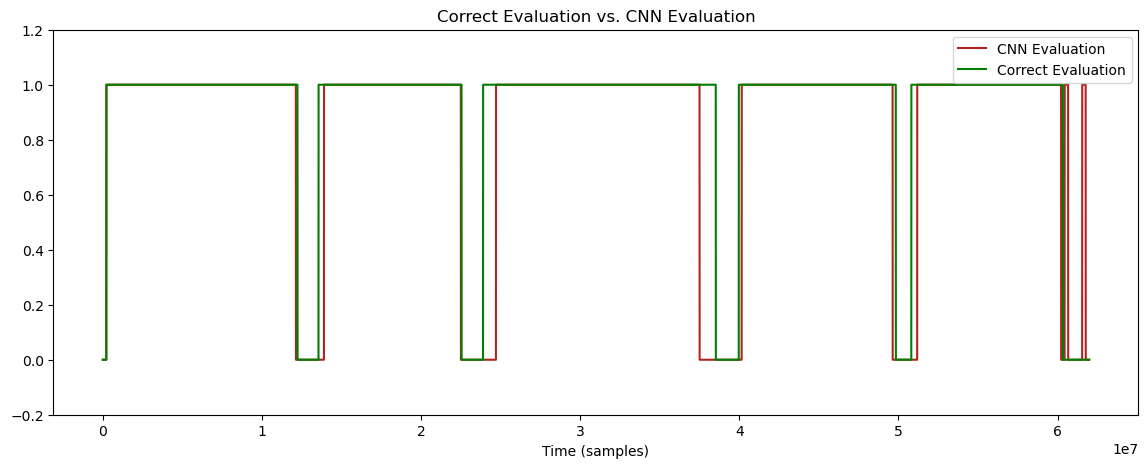

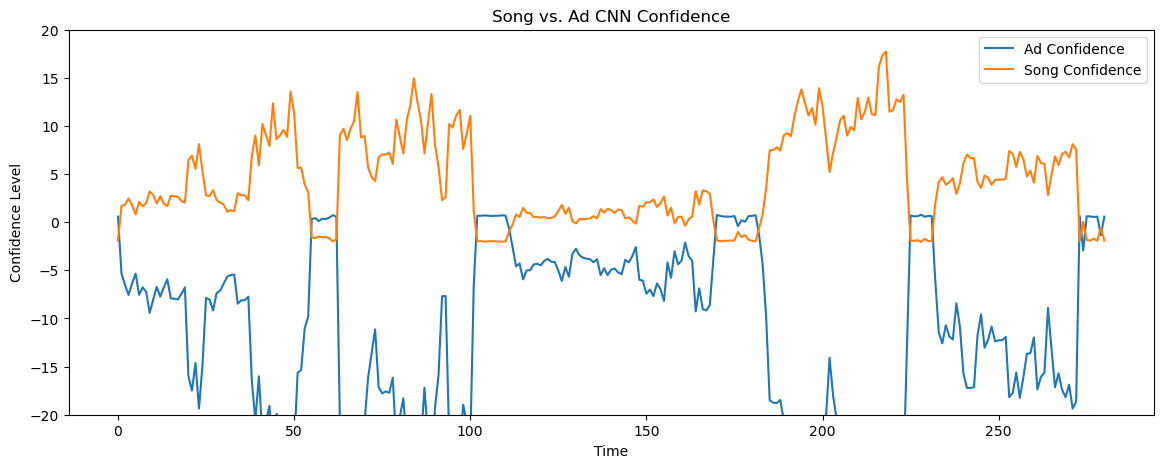

In [22]:
# plot correct eval vs eval
plt.figure(figsize=(14, 5))
plt.plot(audio_eval_raw, label="CNN Evaluation", color='firebrick')
plt.plot(correct_eval, label="Correct Evaluation", color='green')
plt.legend(loc='upper right')
plt.xlabel('Time (samples)')
#plt.xlim(-1.2, 1.2) 
plt.ylim(-0.2, 1.2)
plt.title('Correct Evaluation vs. CNN Evaluation')
plt.savefig(os.path.join("graphics", "raw_eval.png"), transparent=True)
plt.show()

# plot confidences
plt.figure(figsize=(14, 5))
plt.plot(ad_confidence_raw, label='Ad Confidence')
plt.plot(song_confidence_raw, label='Song Confidence')
plt.legend(loc='upper right')
plt.xlabel('Time')
plt.ylabel('Confidence Level')
#plt.xlim(-1.2, 1.2) 
plt.ylim(-20, 20)
plt.title('Song vs. Ad CNN Confidence')
plt.savefig(os.path.join("graphics", "raw_confidence.png"), transparent=True)
plt.show()

# Remove Ads (Raw)

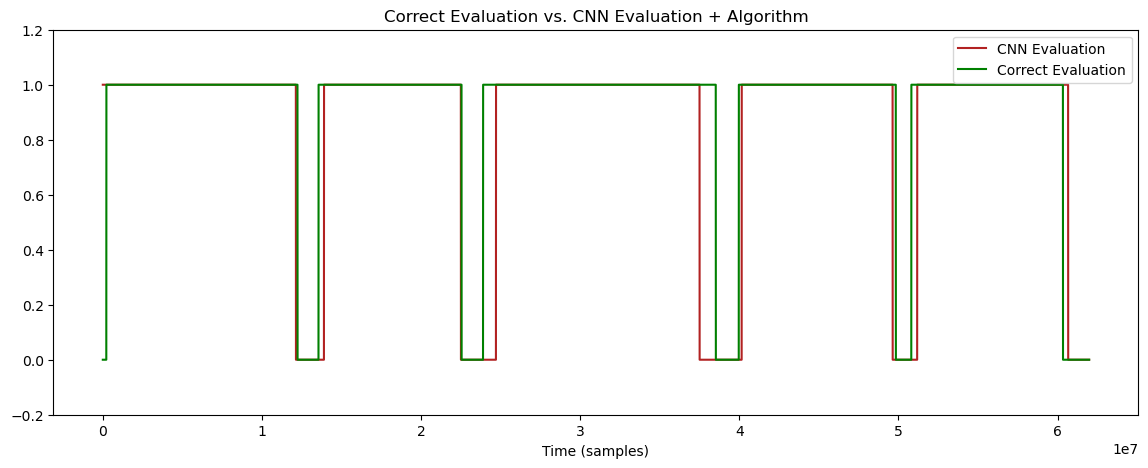

Original Length: 61984421 samples
New Length-Mute: 61984385 samples
New Length-Remove: 52499230 samples


In [23]:
# remove Ads 1 (Raw)
old_eval = audio_eval_raw
algo_eval = []
state = 1
song_tally = 0
ad_tally = 0
threshold = 10*sr # 10 consecutive seconds
    
for i in range(threshold, len(old_eval)):
    if(state == 0):
        algo_eval.append(0)
    else:
        algo_eval.append(1)
    if(old_eval[i] == 0):
        song_tally = 0
        ad_tally += 1
    else:
        ad_tally = 0
        song_tally += 1
    if(song_tally == threshold):
        state = 1
    elif(ad_tally == threshold):
        state = 0

if(state == 1):
    algo_eval.extend(np.ones(threshold))
else:
    algo_eval.extend(np.zeros(threshold))

# plot eval old + new
plt.figure(figsize=(14, 5))
plt.plot(algo_eval, label="CNN Evaluation", color='firebrick')
plt.plot(correct_eval, label="Correct Evaluation", color='green')
plt.legend(loc='upper right')
plt.xlabel('Time (samples)')
#plt.xlim(-1.2, 1.2) 
plt.ylim(-0.2, 1.2)
plt.title('Correct Evaluation vs. CNN Evaluation + Algorithm')
plt.savefig(os.path.join("graphics", "raw_eval_algo_1.png"), transparent=True)
plt.show()

# remove/mute ads
audio_out_mute = []
audio_out_remove = []
for i in range(0, len(algo_eval)):
    if(algo_eval[i] == 0):
        audio_out_mute.append(0)
    else:
        audio_out_mute.append(audio[i])
        audio_out_remove.append(audio[i])

print(f"Original Length: {len(audio)} samples")
print(f"New Length-Mute: {len(audio_out_mute)} samples")
print(f"New Length-Remove: {len(audio_out_remove)} samples")

In [24]:
# write edited audio file
audio_out = np.array(audio_out_mute, dtype=np.float32)
wavfile.write(os.path.join("testing_audio", "raw_output_mute_1.wav"), sr, audio_out)
audio_out = np.array(audio_out_remove, dtype=np.float32)
wavfile.write(os.path.join("testing_audio", "raw_output_removed_1.wav"), sr, audio_out)